Instalar dependencias

In [ ]:
!pip install -U sagemaker

In [4]:
import os
import time
import boto3
import numpy as np
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
from sagemaker.workflow.pipeline_context import PipelineSession

In [5]:
sess = boto3.Session()
sm = sess.client("sagemaker")
role = get_execution_role()
sagemaker_session = sagemaker.Session(boto_session=sess)
bucket = sagemaker_session.default_bucket()
default_bucket_prefix = sagemaker_session.default_bucket_prefix
region = boto3.Session().region_name


In [6]:
bucket, default_bucket_prefix

('sagemaker-us-east-2-244680720635', None)

In [7]:

pipeline_session = PipelineSession() # creo la sesión del pipeline

model_package_group_name = "PipelineModelPackageGroup" # asignamos un nombre al model package 
prefix = "pipeline-model-jei"

# If a default bucket prefix is specified, append it to the s3 path
if default_bucket_prefix:
    prefix = f"{default_bucket_prefix}/{prefix}"

pipeline_name = "jei-pipeline"  # SageMaker Pipeline name

Adquisición de Datos:

In [8]:
data_dir = os.path.join(os.getcwd(), "data")
os.makedirs(data_dir, exist_ok=True)

raw_dir = os.path.join(os.getcwd(), "data/raw")
os.makedirs(raw_dir, exist_ok=True)

In [ ]:
!wget -P data/raw https://archive.ics.uci.edu/static/public/597/productivity+prediction+of+garment+employees.zip --no-check-certificate

In [ ]:
!unzip data/raw/productivity+prediction+of+garment+employees.zip -d data/raw

In [9]:
df = pd.read_csv("data/raw/garments_worker_productivity.csv",sep=",") # leemos los datos
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page


In [10]:
df

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,3/11/2015,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,3/11/2015,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,3/11/2015,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,3/11/2015,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


In [11]:
df.describe

<bound method NDFrame.describe of            date   quarter  department        day  team  targeted_productivity  \
0      1/1/2015  Quarter1      sweing   Thursday     8                   0.80   
1      1/1/2015  Quarter1  finishing    Thursday     1                   0.75   
2      1/1/2015  Quarter1      sweing   Thursday    11                   0.80   
3      1/1/2015  Quarter1      sweing   Thursday    12                   0.80   
4      1/1/2015  Quarter1      sweing   Thursday     6                   0.80   
...         ...       ...         ...        ...   ...                    ...   
1192  3/11/2015  Quarter2   finishing  Wednesday    10                   0.75   
1193  3/11/2015  Quarter2   finishing  Wednesday     8                   0.70   
1194  3/11/2015  Quarter2   finishing  Wednesday     7                   0.65   
1195  3/11/2015  Quarter2   finishing  Wednesday     9                   0.75   
1196  3/11/2015  Quarter2   finishing  Wednesday     6                   0.

In [12]:

#df.to_csv(f"./data/raw/garments_worker_productivity.csv", header=True, index=False)

rawdata_s3_prefix = "{}/data/raw".format(prefix)

raw_s3 = sagemaker_session.upload_data(path="./data/raw/", key_prefix=rawdata_s3_prefix) # lo que tenemos en local en raw lo subimos al s3 
print(raw_s3)

s3://sagemaker-us-east-2-244680720635/pipeline-model-jei/data/raw


Define parametros de PipeLines

In [13]:
from sagemaker.workflow.parameters import ParameterInteger, ParameterString, ParameterFloat

# Datos de entrada 
input_data = ParameterString(name="InputData", default_value=raw_s3)

# Estado del modelo en el registro 
model_approval_status = ParameterString(name="ModelApprovalStatus", default_value="Approved")

# Parámetros del paso de procesamiento 
processing_instance_type = ParameterString(
    name="ProcessingInstanceType", default_value="ml.c4.4xlarge"
)
processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)

# Parámetros de entrenamiento ajustados para XGBoost 
training_instance_type = ParameterString(
    name="TrainingInstanceType", default_value="ml.m5.large"
)
num_rounds = ParameterInteger(name="NumRounds", default_value=100)

# Parámetro de rendimiento del modelo (sin cambios)
accuracy_mse_threshold = ParameterFloat(name="AccuracyMseThreshold", default_value=0.75)


In [ ]:
!mkdir -p code

In [14]:
%%writefile code/preprocess.py

import glob
import numpy as np
import pandas as pd
import os
import json
import joblib
from io import StringIO
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import tarfile

try:
    from sagemaker_containers.beta.framework import (
        content_types,
        encoders,
        env,
        modules,
        transformer,
        worker,
        server,
    )
except ImportError:
    pass

# Columnas definidas
feature_columns = [
    "department",            # categórica -> OneHot
    "date", "quarter", "day",# ordinal
    "team",
    "targeted_productivity",
    "smv",
    "wip",
    "over_time",
    "incentive",
    "idle_time",
    "idle_men",
    "no_of_style_change",
    "no_of_workers"
]
label_column = "actual_productivity"

# Clasificación de columnas
ohe_vars = ["department"]
ordinal_vars = ["date", "quarter", "day"]
num_vars = [col for col in feature_columns if col not in ohe_vars + ordinal_vars]

# Rutas base
base_dir = "/opt/ml/processing"
base_output_dir = "/opt/ml/output/"

if __name__ == "__main__":
    df = pd.read_csv(f"{base_dir}/input/garments_worker_productivity.csv")
    feature_data = df[feature_columns]
    label_data = df[label_column]

    # Split
    x_train, x_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.33)

    # Pipeline de preprocesamiento
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_vars),
            ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ohe_vars),
            ('ord', OrdinalEncoder(), ordinal_vars)
        ]
    )

    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    # Fit y transform
    x_train_processed = pipeline.fit_transform(x_train)
    x_test_processed = pipeline.transform(x_test)

    # Recuperar nombres de columnas procesadas
    cat_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(ohe_vars).tolist()
    feature_names = num_vars + cat_names + ordinal_vars

    # Construcción final de DataFrames
    train_dataset = pd.concat(
        [pd.DataFrame(x_train_processed, columns=feature_names), y_train.reset_index(drop=True)], axis=1
    )
    test_dataset = pd.concat(
        [pd.DataFrame(x_test_processed, columns=feature_names), y_test.reset_index(drop=True)], axis=1
    )

    # Crear directorios
    os.makedirs(f"{base_dir}/train", exist_ok=True)
    os.makedirs(f"{base_dir}/test", exist_ok=True)

    # Guardar CSVs con nombres reales
    train_dataset.to_csv(f"{base_dir}/train/train.csv", header=True, index=False)
    test_dataset.to_csv(f"{base_dir}/test/test.csv", header=True, index=False)

    # Guardar modelo preprocesador
    os.makedirs(f"{base_dir}/scaler_model", exist_ok=True)
    joblib.dump(pipeline, "model.joblib")
    with tarfile.open(f"{base_dir}/scaler_model/model.tar.gz", "w:gz") as tar_handle:
        tar_handle.add("model.joblib")


# Función de entrada (input_fn)
def input_fn(input_data, content_type):
    if content_type == "text/csv":
        df = pd.read_csv(StringIO(input_data), header=None)
        if len(df.columns) == len(feature_columns) + 1:
            df.columns = feature_columns + [label_column]
        elif len(df.columns) == len(feature_columns):
            df.columns = feature_columns
        return df
    else:
        raise ValueError("{} not supported by script!".format(content_type))

# Función de salida (output_fn)
def output_fn(prediction, accept):
    if accept == "application/json":
        instances = [row for row in prediction.tolist()]
        return worker.Response(json.dumps({"instances": instances}), mimetype=accept)
    elif accept == "text/csv":
        return worker.Response(encoders.encode(prediction, accept), mimetype=accept)
    else:
        raise RuntimeError("{} accept type is not supported by this script.".format(accept))


Overwriting code/preprocess.py


In [11]:
input_data

ParameterString(name='InputData', parameter_type=<ParameterTypeEnum.STRING: 'String'>, default_value='s3://sagemaker-us-east-2-244680720635/pipeline-model-jei/data/raw')

Ejecucion del procesor

In [15]:
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

sklearn_framework_version = "1.2-1"

sklearn_processor = SKLearnProcessor(
    framework_version=sklearn_framework_version,
    instance_type="ml.c4.4xlarge",
    instance_count=processing_instance_count,
    base_job_name="sklearn-housing-data-process",
    role=role,
    sagemaker_session=pipeline_session,
)

processor_args = sklearn_processor.run(
    inputs=[
        ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),
    ],
    outputs=[
        ProcessingOutput(output_name="scaler_model", source="/opt/ml/processing/scaler_model"),
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test"),
    ],
    code="code/preprocess.py",
)

[04/10/25 20:47:08] INFO     Defaulting to only available Python version: py3                     ]8;id=666865;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=336044;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#610\610]8;;\

/opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


In [16]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep


# firt step para pipeline 
step_process = ProcessingStep(
    name="PreprocessData",
    step_args=processor_args,
)

In [17]:
import os

# Intenta obtener las variables de entorno
train_data_dir = os.environ.get("SM_CHANNEL_TRAIN")
test_data_dir = os.environ.get("SM_CHANNEL_TEST")

print(f'Train Data Directory: {train_data_dir}')
print(f'Test Data Directory: {test_data_dir}')

Train Data Directory: None
Test Data Directory: None


In [15]:
!pip install -U sagemaker xgboost

In [18]:

from sagemaker.xgboost.estimator import XGBoost

xgb_estimator = XGBoost(
    entry_point="train.py",
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    framework_version="1.7-1",
    py_version="py3",
    base_job_name="xgboost-pipeline-model",
    output_path=f"s3://{bucket}/{prefix}/training-jobs"
)


[04/10/25 20:47:12] INFO     Ignoring unnecessary Python version: py3.                            ]8;id=58404;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=403902;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#603\603]8;;\

                    INFO     Ignoring unnecessary instance type: ml.m5.large.                     ]8;id=647250;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=813012;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [19]:
%%writefile code/train.py

import argparse
import os
import pandas as pd
import xgboost as xgb
import json
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

label_column = "actual_productivity"

def parse_args():
    parser = argparse.ArgumentParser()

    # Hyperparameters from SageMaker
    parser.add_argument("--objective", type=str, default="reg:squarederror")
    parser.add_argument("--num_round", type=int, default=100)
    parser.add_argument("--max_depth", type=int, default=4)
    parser.add_argument("--eta", type=float, default=0.2)

    # SageMaker paths
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--sm-model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))

    return parser.parse_args()

if __name__ == "__main__":
    args = parse_args()

    # Cargar datos
    train_df = pd.read_csv(os.path.join(args.train, "train.csv"))
    test_df = pd.read_csv(os.path.join(args.test, "test.csv"))

    X_train = train_df.drop(columns=[label_column])
    y_train = train_df[label_column]
    X_test = test_df.drop(columns=[label_column])
    y_test = test_df[label_column]

    # Definir modelo
    model = xgb.XGBRegressor(
        objective=args.objective,
        n_estimators=args.num_round,
        max_depth=args.max_depth,
        eta=args.eta
    )

    # Validación cruzada
    print("Realizando validación cruzada (5-fold)...")
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=mse_scorer)
    mse_scores = -scores  # Convertimos a positivos

    print(f"MSE por fold: {mse_scores}")
    print(f"MSE promedio: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")

    # Guardar resultados de CV
    cv_results_path = os.path.join(args.sm_model_dir, "cv_results.json")
    cv_dict = {
        "fold_mse": mse_scores.tolist(),
        "mean_mse": float(np.mean(mse_scores)),
        "std_mse": float(np.std(mse_scores))
    }
    with open(cv_results_path, "w") as f:
        json.dump(cv_dict, f)

    # Entrenamiento final completo
    model.fit(X_train, y_train)

    # Guardar modelo en formato .bst (requerido por contenedor de SageMaker XGBoost)
    model_output_path = os.path.join(args.sm_model_dir, "xgboost-model.bst")
    model.get_booster().save_model(model_output_path)

    # Guardar columnas de entrada
    input_columns_path = os.path.join(args.sm_model_dir, "input_columns.json")
    with open(input_columns_path, "w") as f:
        json.dump(list(X_train.columns), f)


Overwriting code/train.py


In [20]:
from sagemaker.inputs import TrainingInput
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.workflow.steps import TrainingStep

# Dónde almacenar el modelo entrenado
model_path = f"s3://{bucket}/{prefix}/model/"
#Hiperparametros
hyperparameters = {
    "objective": "reg:squarederror",
    "num_round": num_rounds,
    "max_depth": 5,
    "eta": 0.2,
}

# Define el estimator de XGBoost
xgb_estimator = XGBoost(
    entry_point="train.py",
    source_dir="code",
    framework_version="1.7-1",
    py_version="py3",
    role=role,
    instance_type=training_instance_type,
    instance_count=1,
    hyperparameters=hyperparameters,
    base_job_name="xgboost-train-model",
    output_path=model_path,
    sagemaker_session=pipeline_session,
)


# Definir los argumentos para entrenamiento con XGBoost
train_args = xgb_estimator.fit(
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri,
            content_type="text/csv",
        ),
        "test": TrainingInput(  # <-- este debe llamarse "test"
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
            content_type="text/csv",
        ),
    }
)


# Paso de entrenamiento ajustado
step_train_model = TrainingStep(
    name="TrainXGBoostModel",
    step_args=train_args
)


[04/10/25 20:47:13] WARNING  The input argument instance_type of function                          ]8;id=613121;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=26978;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#422\422]8;;\
                             (sagemaker.image_uris.retrieve) is a pipeline variable (<class                        
                             'sagemaker.workflow.parameters.ParameterString'>), which is                           
                             interpreted in pipeline execution time only. As the function needs to                 
                             evaluate the argument value in SDK compile time, the default_value of                 
                             this Parameter object will be used to override it. Please make sure                   
                             the default_value is valid.                                                           

                    INFO     Ignoring unnecessary Python version: py3.                            ]8;id=682775;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=788537;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#603\603]8;;\

                    INFO     Ignoring unnecessary instance type: ml.m5.large.                     ]8;id=704760;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=920964;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=954036;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=781345;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

In [33]:
%%writefile code/evaluate.py

import os
import json
import numpy as np
import pandas as pd
import pathlib
import tarfile
import xgboost as xgb
from sklearn.metrics import mean_squared_error

label_column = "actual_productivity"

if __name__ == "__main__":
    model_path = "/opt/ml/processing/model/model.tar.gz"
    with tarfile.open(model_path, "r:gz") as tar:
        tar.extractall("./model")

    # Cargar el modelo en formato .bst
    booster = xgb.Booster()
    booster.load_model("./model/xgboost-model.bst")

    # Cargar columnas esperadas
    with open("./model/input_columns.json", "r") as f:
        input_columns = json.load(f)

    # Cargar y procesar dataset de test
    test_path = "/opt/ml/processing/test/"
    df = pd.read_csv(test_path + "test.csv")
    df = pd.get_dummies(df, columns=["team"])

    # Agregar columnas faltantes con 0 y ordenar
    for col in input_columns:
        if col not in df.columns:
            df[col] = 0
    df = df[input_columns + [label_column]]  # Orden correcto

    # Preparar datos
    x_test = df[input_columns].to_numpy()
    y_test = df[label_column].to_numpy()

    # Convertir a DMatrix
    dtest = xgb.DMatrix(x_test)

    # Evaluar modelo
    predictions = booster.predict(dtest)
    mse = mean_squared_error(y_test, predictions)
    print("\nTest MSE :", mse)

    # Reporte para SageMaker
    report_dict = {
        "regression_metrics": {
            "mse": {"value": float(mse), "standard_deviation": "NaN"},
        },
    }

    output_dir = "/opt/ml/processing/evaluation"
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

    evaluation_path = f"{output_dir}/evaluation.json"
    with open(evaluation_path, "w") as f:
        f.write(json.dumps(report_dict))


Overwriting code/evaluate.py


In [34]:
from sagemaker.workflow.properties import PropertyFile
from sagemaker.sklearn.processing import ScriptProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep


# Utilizar imagen oficial de SKLearn para procesamiento
sklearn_eval_image_uri = sagemaker.image_uris.retrieve(
    framework="sklearn",
    region=region,
    version="1.2-1",
    instance_type=processing_instance_type,
    image_scope="training"
)

evaluate_model_processor = ScriptProcessor(
    role=role,
    image_uri=sklearn_eval_image_uri,
    command=["python3"],
    instance_count=1,
    instance_type=processing_instance_type,
    sagemaker_session=pipeline_session,
)

evaluation_report = PropertyFile(
    name="EvaluationReport", output_name="evaluation", path="evaluation.json"
)

eval_args = evaluate_model_processor.run(
    inputs=[
        ProcessingInput(
            source=step_train_model.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model",
        ),
        ProcessingInput(
            source=step_process.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
            destination="/opt/ml/processing/test",
        ),
    ],
    outputs=[
        ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
    ],
    code="code/evaluate.py",
)

step_evaluate_model = ProcessingStep(
    name="EvaluateModelPerformance",
    step_args=eval_args,
    property_files=[evaluation_report],
)


[04/10/25 20:56:25] WARNING  The input argument instance_type of function                          ]8;id=835150;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=863866;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#422\422]8;;\
                             (sagemaker.image_uris.retrieve) is a pipeline variable (<class                        
                             'sagemaker.workflow.parameters.ParameterString'>), which is                           
                             interpreted in pipeline execution time only. As the function needs to                 
                             evaluate the argument value in SDK compile time, the default_value of                 
                             this Parameter object will be used to override it. Please make sure                   
                             the default_value is valid.                                                           

                    INFO     Defaulting to only available Python version: py3                     ]8;id=706642;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=701490;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#610\610]8;;\

In [35]:
from sagemaker.workflow.properties import PropertyFile
from sagemaker.processing import ScriptProcessor, ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep
import sagemaker

# Obtener la imagen de procesamiento XGBoost oficial de SageMaker
xgb_eval_image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.7-1",
    instance_type=processing_instance_type,
    image_scope="training",  # Aunque no sea entrenamiento, funciona bien para procesamiento
)

# ScriptProcessor con imagen de XGBoost
evaluate_model_processor = ScriptProcessor(
    role=role,
    image_uri=xgb_eval_image_uri,
    command=["python3"],
    instance_count=1,
    instance_type=processing_instance_type,
    sagemaker_session=pipeline_session,
)

# Archivo de salida para condiciones posteriores
evaluation_report = PropertyFile(
    name="EvaluationReport", output_name="evaluation", path="evaluation.json"
)

# Configurar los argumentos del step de evaluación
eval_args = evaluate_model_processor.run(
    inputs=[
        ProcessingInput(
            source=step_train_model.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model",
        ),
        ProcessingInput(
            source=step_process.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
            destination="/opt/ml/processing/test",
        ),
    ],
    outputs=[
        ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
    ],
    code="code/evaluate.py",
)

# Crear el paso en el pipeline
step_evaluate_model = ProcessingStep(
    name="EvaluateModelPerformance",
    step_args=eval_args,
    property_files=[evaluation_report],
)


[04/10/25 20:56:26] WARNING  The input argument instance_type of function                          ]8;id=777675;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=413691;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#422\422]8;;\
                             (sagemaker.image_uris.retrieve) is a pipeline variable (<class                        
                             'sagemaker.workflow.parameters.ParameterString'>), which is                           
                             interpreted in pipeline execution time only. As the function needs to                 
                             evaluate the argument value in SDK compile time, the default_value of                 
                             this Parameter object will be used to override it. Please make sure                   
                             the default_value is valid.                                                           

                    INFO     Ignoring unnecessary instance type: ml.c4.4xlarge.                   ]8;id=963200;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=665937;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [36]:
pipeline_session

In [37]:
from sagemaker.model_metrics import MetricsSource, ModelMetrics
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.workflow.model_step import ModelStep  # Asegúrate de importar ModelStep
from sagemaker.pipeline import PipelineModel
from sagemaker.xgboost.model import XGBoostModel

evaluation_s3_uri = "{}/evaluation.json".format(
    step_evaluate_model.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
)

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri=evaluation_s3_uri,
        content_type="application/json",
    )
)

xgb_model = XGBoostModel(
    model_data=step_train_model.properties.ModelArtifacts.S3ModelArtifacts,
    role=role,
    framework_version="1.7-1",
    py_version="py3",
    sagemaker_session=pipeline_session,
)

register_args = xgb_model.register(
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.m5.large", "ml.m5.xlarge"],
    transform_instances=["ml.m5.large"],
    model_package_group_name=model_package_group_name,
    model_metrics=model_metrics,
    approval_status=model_approval_status,
)

step_register_pipeline_model = ModelStep(
    name="RegisterXGBoostModel",
    step_args=register_args,
)


[04/10/25 20:56:28] WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=2433;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=518145;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    INFO     Ignoring unnecessary instance type: ml.m5.large.                     ]8;id=820166;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=413105;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

DEFINICION DE HIPERPARAMETROS, ACCURACY

In [38]:
from sagemaker.workflow.functions import JsonGet, Join
from sagemaker.workflow.conditions import ConditionLessThanOrEqualTo
from sagemaker.workflow.condition_step import ConditionStep

cond_lte = ConditionLessThanOrEqualTo(
    left=JsonGet(
        step_name=step_evaluate_model.name,
        property_file=evaluation_report,
        json_path="regression_metrics.mse.value",
    ),
    right=accuracy_mse_threshold,
)

step_cond = ConditionStep(
    name="MSE-Lower-Than-Threshold-Condition",
    conditions=[cond_lte],
    if_steps=[step_register_pipeline_model],
    else_steps=[],
)


In [39]:
from sagemaker.workflow.pipeline import Pipeline

pipeline = Pipeline(
    name=pipeline_name,
       parameters=[
        training_instance_type,
        processing_instance_type,
        processing_instance_count,
        input_data,
        model_approval_status,
        num_rounds,  
        accuracy_mse_threshold,
    ],
    steps=[
        step_process,                 
        step_train_model,             
        step_evaluate_model,          
        step_cond,                    
    ],
)


In [40]:
import json

definition = json.loads(pipeline.definition())
definition

[04/10/25 20:56:32] WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=980030;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=2071;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  The input argument instance_type of function                          ]8;id=246256;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=687937;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#422\422]8;;\
                             (sagemaker.image_uris.get_training_image_uri) is a pipeline variable                  
                             (<class 'sagemaker.workflow.parameters.ParameterString'>), which is                   
                             interpreted in pipeline execution time only. As the function needs to                 
                             evaluate the argument value in SDK compile time, the default_value of                 
                             this Parameter object will be used to override it. Please make sure                   
                             the default_value is valid.                                                           

                    WARNING  Popping out 'TrainingJobName' from the pipeline definition by default ]8;id=817189;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=226244;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             since it will be overridden at pipeline execution time. Please                        
                             utilize the PipelineDefinitionConfig to persist this field in the                     
                             pipeline definition if desired.                                                       

                    WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=379136;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=103978;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  Popping out 'CertifyForMarketplace' from the pipeline definition since   ]8;id=374072;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/_utils.py\_utils.py]8;;\:]8;id=243823;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/_utils.py#515\515]8;;\
                             it will be overridden in pipeline execution time.                                     

                    WARNING  Popping out 'ModelPackageName' from the pipeline definition by        ]8;id=897221;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=457056;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

{'Version': '2020-12-01',
 'Metadata': {},
 'Parameters': [{'Name': 'TrainingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.m5.large'},
  {'Name': 'ProcessingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.c4.4xlarge'},
  {'Name': 'ProcessingInstanceCount', 'Type': 'Integer', 'DefaultValue': 1},
  {'Name': 'InputData',
   'Type': 'String',
   'DefaultValue': 's3://sagemaker-us-east-2-244680720635/pipeline-model-jei/data/raw'},
  {'Name': 'ModelApprovalStatus',
   'Type': 'String',
   'DefaultValue': 'Approved'},
  {'Name': 'NumRounds', 'Type': 'Integer', 'DefaultValue': 100},
  {'Name': 'AccuracyMseThreshold', 'Type': 'Float', 'DefaultValue': 0.75}],
 'PipelineExperimentConfig': {'ExperimentName': {'Get': 'Execution.PipelineName'},
  'TrialName': {'Get': 'Execution.PipelineExecutionId'}},
 'Steps': [{'Name': 'PreprocessData',
   'Type': 'Processing',
   'Arguments': {'ProcessingResources': {'ClusterConfig': {'InstanceType': 'ml.c4.4xlarge',
      'InstanceCount':

Enviar modelo a Sage Maker

In [41]:
role

'arn:aws:iam::244680720635:role/service-role/AmazonSageMaker-ExecutionRole-20250407T184774'

In [42]:
pipeline.upsert(role_arn=role)

[04/10/25 20:56:36] WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=306497;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=348169;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  The input argument instance_type of function                          ]8;id=632982;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=484989;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#422\422]8;;\
                             (sagemaker.image_uris.get_training_image_uri) is a pipeline variable                  
                             (<class 'sagemaker.workflow.parameters.ParameterString'>), which is                   
                             interpreted in pipeline execution time only. As the function needs to                 
                             evaluate the argument value in SDK compile time, the default_value of                 
                             this Parameter object will be used to override it. Please make sure                   
                             the default_value is valid.                                                           

                    WARNING  Popping out 'TrainingJobName' from the pipeline definition by default ]8;id=473100;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=143306;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             since it will be overridden at pipeline execution time. Please                        
                             utilize the PipelineDefinitionConfig to persist this field in the                     
                             pipeline definition if desired.                                                       

                    WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=83328;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=699057;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  Popping out 'ModelPackageName' from the pipeline definition by        ]8;id=303611;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=892524;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=247276;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=486035;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  The input argument instance_type of function                          ]8;id=889800;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=333154;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#422\422]8;;\
                             (sagemaker.image_uris.get_training_image_uri) is a pipeline variable                  
                             (<class 'sagemaker.workflow.parameters.ParameterString'>), which is                   
                             interpreted in pipeline execution time only. As the function needs to                 
                             evaluate the argument value in SDK compile time, the default_value of                 
                             this Parameter object will be used to override it. Please make sure                   
                             the default_value is valid.                                                           

                    WARNING  Popping out 'TrainingJobName' from the pipeline definition by default ]8;id=97518;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=278574;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             since it will be overridden at pipeline execution time. Please                        
                             utilize the PipelineDefinitionConfig to persist this field in the                     
                             pipeline definition if desired.                                                       

                    WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=382023;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=144023;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  Popping out 'ModelPackageName' from the pipeline definition by        ]8;id=151299;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=551287;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

{'PipelineArn': 'arn:aws:sagemaker:us-east-2:244680720635:pipeline/jei-pipeline',
 'ResponseMetadata': {'RequestId': '273f0344-cb93-4d9f-b81b-cf364d923558',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '273f0344-cb93-4d9f-b81b-cf364d923558',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '80',
   'date': 'Thu, 10 Apr 2025 20:56:37 GMT'},
  'RetryAttempts': 0}}

In [43]:
execution = pipeline.start()

In [44]:
execution.wait()

End Point

In [47]:
%%writefile utils.py
import argparse
import boto3
import logging
import os
from botocore.exceptions import ClientError
import tarfile
import zipfile

logger = logging.getLogger(__name__)
sm_client = boto3.client("sagemaker")


def get_approved_package(model_package_group_name):
    """Gets the latest approved model package for a model package group.

    Args:
        model_package_group_name: The model package group name.

    Returns:
        The SageMaker Model Package ARN.
    """
    try:
        # Get the latest approved model package
        response = sm_client.list_model_packages(
            ModelPackageGroupName=model_package_group_name,
            ModelApprovalStatus="Approved",
            SortBy="CreationTime",
            MaxResults=100,
        )
        approved_packages = response["ModelPackageSummaryList"]

        # Fetch more packages if none returned with continuation token
        while len(approved_packages) == 0 and "NextToken" in response:
            logger.debug("Getting more packages for token: {}".format(response["NextToken"]))
            response = sm_client.list_model_packages(
                ModelPackageGroupName=model_package_group_name,
                ModelApprovalStatus="Approved",
                SortBy="CreationTime",
                MaxResults=100,
                NextToken=response["NextToken"],
            )
            approved_packages.extend(response["ModelPackageSummaryList"])

        # Return error if no packages found
        if len(approved_packages) == 0:
            error_message = (
                f"No approved ModelPackage found for ModelPackageGroup: {model_package_group_name}"
            )
            logger.error(error_message)
            raise Exception(error_message)

        # Return the pmodel package arn
        model_package_arn = approved_packages[0]["ModelPackageArn"]
        logger.info(f"Identified the latest approved model package: {model_package_arn}")
        return approved_packages[0]
        # return model_package_arn
    except ClientError as e:
        error_message = e.response["Error"]["Message"]
        logger.error(error_message)
        raise Exception(error_message)

Overwriting utils.py


In [48]:
from utils import get_approved_package

sm_client = boto3.client("sagemaker")

pck = get_approved_package(
    model_package_group_name
)  # Reminder: model_package_group_name was defined as "NominetAbaloneModelPackageGroupName" at the beginning of the pipeline definition
model_description = sm_client.describe_model_package(ModelPackageName=pck["ModelPackageArn"])

model_description

[04/10/25 21:49:26] INFO     Identified the latest approved model package:                              ]8;id=432908;file:///home/sagemaker-user/utils.py\utils.py]8;;\:]8;id=602243;file:///home/sagemaker-user/utils.py#54\54]8;;\
                             arn:aws:sagemaker:us-east-2:244680720635:model-package/PipelineModelPackag            
                             eGroup/3                                                                              

{'ModelPackageGroupName': 'PipelineModelPackageGroup',
 'ModelPackageVersion': 3,
 'ModelPackageArn': 'arn:aws:sagemaker:us-east-2:244680720635:model-package/PipelineModelPackageGroup/3',
 'CreationTime': datetime.datetime(2025, 4, 10, 21, 4, 34, 73000, tzinfo=tzlocal()),
 'InferenceSpecification': {'Containers': [{'Image': '257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-xgboost:1.7-1',
    'ImageDigest': 'sha256:4b6084d53c814933b0d764466f4d3196e2ed350910e34901bb3aa4bce222d8a2',
    'ModelDataUrl': 's3://sagemaker-us-east-2-244680720635/pipeline-model-jei/model/pipelines-356u4aasduml-TrainXGBoostModel-AHWWPWOiPc/output/model.tar.gz',
    'Environment': {'SAGEMAKER_CONTAINER_LOG_LEVEL': '20',
     'SAGEMAKER_REGION': 'us-east-2'},
    'Framework': 'XGBOOST',
    'ModelDataETag': '00d0c0580268167094cbbcacdb9b83cd'}],
  'SupportedTransformInstanceTypes': ['ml.m5.large'],
  'SupportedRealtimeInferenceInstanceTypes': ['ml.m5.large', 'ml.m5.xlarge'],
  'SupportedContentTypes': ['text

In [ ]:
from sagemaker import ModelPackage

model_package_arn = model_description["ModelPackageArn"]
model = ModelPackage(
    role=role, model_package_arn=model_package_arn, sagemaker_session=sagemaker_session
)

endpoint_name = "XGBoost-endpoint-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print("EndpointName= {}".format(endpoint_name))
model.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge", endpoint_name=endpoint_name)

EndpointName= XGBoost-endpoint-2025-04-11-01-12-29


[04/11/25 01:12:29] INFO     Creating model with name:                                              ]8;id=156195;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=372132;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4094\4094]8;;\
                             PipelineModelPackageGroup-2025-04-11-01-12-29-835                                     

[04/11/25 01:12:35] INFO     Creating endpoint-config with name                                     ]8;id=124625;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=500134;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#5889\5889]8;;\
                             XGBoost-endpoint-2025-04-11-01-12-29                                                  

                    INFO     Creating endpoint with name XGBoost-endpoint-2025-04-11-01-12-29       ]8;id=678377;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=241032;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4711\4711]8;;\

----------------------

In [103]:
from sagemaker.predictor import Predictor

predictor = Predictor(endpoint_name=endpoint_name)

In [ ]:
data = pd.read_csv("data/raw/garments_worker_productivity.csv")
productivity = data["actual_productivity"]
data = data.drop("actual_productivity", axis=1)

pred_count = 10
payload = data.iloc[:pred_count].to_csv(header=False, index=False)
p = predictor.predict(payload, initial_args={"ContentType": "text/csv"})
print(p.decode("utf-8"))

In [ ]:
blue, stop = "\033[94m", "\033[0m"
predictions = json.loads(p.decode("utf-8"))["predictions"]
for i in range(pred_count):
    print(
        f"Predicted: {blue}{predictions[i][0]}{stop} and Actual is: {blue}{productivity.iloc[i]}{stop}"
    )

Depurado Endpoint

In [ ]:
sm_client = boto3.client("sagemaker")

for d in sm_client.list_model_packages(ModelPackageGroupName=model_package_group_name)[
    "ModelPackageSummaryList"
]:
    print(d["ModelPackageArn"])
    sm_client.delete_model_package(ModelPackageName=d["ModelPackageArn"])

sm_client.delete_model_package_group(ModelPackageGroupName=model_package_group_name)

In [ ]:
predictor.delete_endpoint()

In [ ]:
pipeline.delete()

✅ Archivo test.csv descargado desde S3.
✅ Modelo cargado.


/opt/conda/lib/python3.11/pickle.py:1718: UserWarning: [04:36:04] WARNING: /workspace/src/collective/../data/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


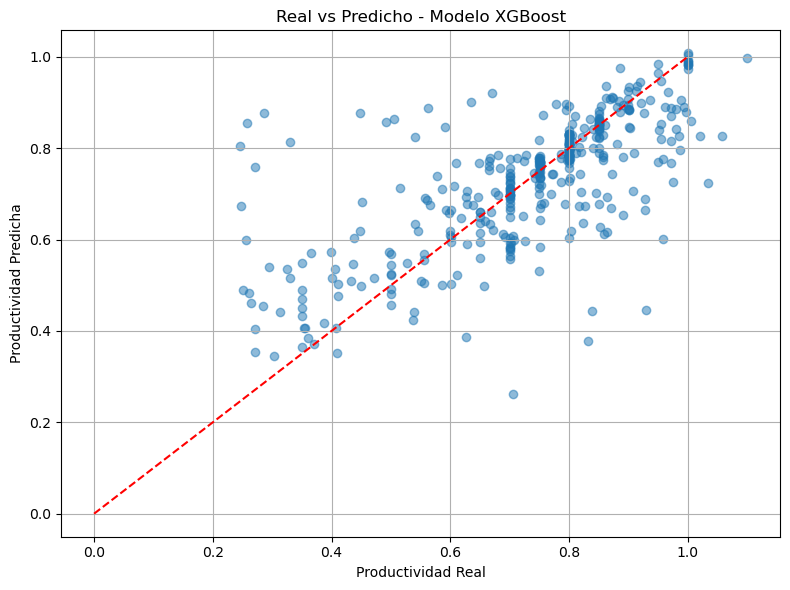

📊 MSE: 0.0166
📊 R2 Score: 0.4845


In [83]:
import os
import json
import joblib
import boto3
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# ---------- CONFIGURACIÓN ----------
bucket = "sagemaker-us-east-2-244680720635"
key = "jei-pipeline/isagz6pccqh3/PreprocessData/output/test/test.csv"
local_test_path = "test.csv"

# ---------- DESCARGAR TEST SET ----------
s3 = boto3.client("s3")
s3.download_file(bucket, key, local_test_path)
print("✅ Archivo test.csv descargado desde S3.")

# ---------- CARGAR MODELO ----------
model = joblib.load("model/xgboost-model.joblib")
print("✅ Modelo cargado.")

# ---------- CARGAR COLUMNAS DE ENTRADA ----------
with open("model/input_columns.json", "r") as f:
    input_columns = json.load(f)

# ---------- PREPROCESAR TEST ----------
df = pd.read_csv(local_test_path)

for col in input_columns:
    if col not in df.columns:
        df[col] = 0

df = df[input_columns + ["actual_productivity"]]
X_test = df[input_columns]
y_test = df["actual_productivity"]

# ---------- PREDICCIONES ----------
y_pred = model.predict(X_test)

# ---------- GRÁFICA: Real vs Predicho ----------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Productividad Real")
plt.ylabel("Productividad Predicha")
plt.title("Real vs Predicho - Modelo XGBoost")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- MÉTRICAS ----------
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 MSE: {mse:.4f}")
print(f"📊 R2 Score: {r2:.4f}")


In [85]:
import boto3
import json

# Parámetros S3
bucket = "sagemaker-us-east-2-244680720635"
key = "sagemaker-xgboost-2025-04-09-02-42-27-711/output/evaluation/evaluation.json"

# Cliente S3
s3 = boto3.client("s3")

# Obtener el archivo
response = s3.get_object(Bucket=bucket, Key=key)
content = response["Body"].read().decode("utf-8")
report = json.loads(content)

# Mostrar resultados
mse = report["regression_metrics"]["mse"]["value"]
print(f"📊 MSE obtenido: {mse:.4f}")


📊 MSE obtenido: 0.0171
